In [1]:
from google.colab import userdata
!pip install -qU "langchain-community>=0.2.11" tavily-python
key = userdata.get('TAVILY_API_KEY')
import subprocess
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = key
def check_and_install(package_name):
    try:
        subprocess.check_output(['pip', 'show', package_name])
    except subprocess.CalledProcessError:
        print(f"{package_name} not found, installing...")
        subprocess.check_output(['pip', 'install', package_name])
    else:
        print(f"{package_name} already installed.")

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')

check_and_install('langchain_community')
check_and_install('langchain')
check_and_install('openai')
check_and_install('python-dotenv')
check_and_install('tiktoken')
check_and_install('langchain_openai')
check_and_install('google-colab')
check_and_install('langgraph')
check_and_install('chromadb')
check_and_install('langchain_experimental')
!pip install --upgrade langchain
!pip install langgraph
!pip install chromadb

oai_key = userdata.get('OPENAI_API_KEY')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.1 MB/s eta 0:00:00
Running on CoLab
langchain_community already installed.
langchain already installed.
openai already installed.
python-dotenv already installed.
tiktoken already installed.
langchain_openai not found, installing...
google-colab already installed.
langgraph not found, installing...
chromadb not found, installing...
langchain_experimental not found, installing...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.16
    Uninstalling langchain-0.3.16:
      Successfully uninstalled langchain-0.3.16


In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [3]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini", api_key=oai_key)
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [4]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', additional_kwargs={}, response_metadata={}, id='a647e2d8-291b-4d05-82d7-acf512c4d968'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zdNsq1B576HWAOjIeS3ReDmC', 'function': {'arguments': '{"query":"US Open 2023 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 95, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dd040302-1872-4185-bf2e-07ee3dfb55c2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US Open 2023 winner'}, 'id': 'call_zdNsq1B576H

In [5]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [6]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [7]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0, api_key=oai_key
).with_structured_output(Plan)

In [8]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current year to determine the most recent Australia Open winner.', 'Research the winner of the Australia Open for the current year.', 'Find the hometown of the identified winner from the Australia Open.'])

In [10]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0, api_key=oai_key
).with_structured_output(Act)

In [11]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [12]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

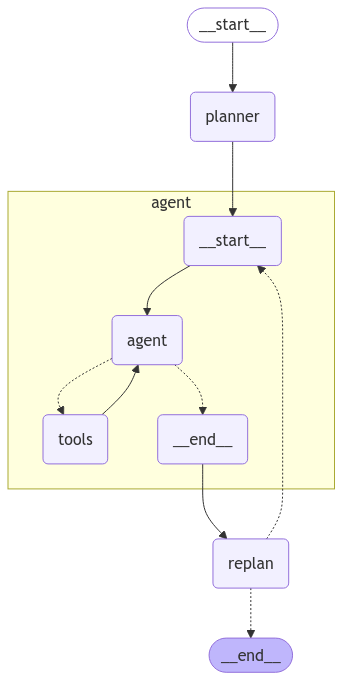

In [13]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [14]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the winner of the men's 2024 Australian Open.", "Research the winner's personal background to find their hometown.", 'Verify the information from a reliable source to ensure accuracy.', 'Record the hometown as the final answer.']}
{'past_steps': [("Identify the winner of the men's 2024 Australian Open.", "The winner of the men's singles at the 2024 Australian Open is **Jannik Sinner**.")]}
{'plan': ["Research Jannik Sinner's personal background to find his hometown.", 'Verify the information from a reliable source to ensure accuracy.', "Record Jannik Sinner's hometown as the final answer."]}
{'past_steps': [("Research Jannik Sinner's personal background to find his hometown.", "I found information regarding Jannik Sinner's hometown. He is from Sesto Pusteria, also known as Sexten, which is located in the Trentino Alto Adige region of northern Italy, between the Alps. \n\nNext, I will verify this information from a reliable source.")]}
{'response': "The information r